In [1]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Import Library

In [2]:
import os
import cv2 as cv
import numpy as np
import itertools
import keras
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121, ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Activation, BatchNormalization, Dropout, GlobalAveragePooling2D
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical
from keras.models import Sequential
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

2024-06-25 23:19:31.602870: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-25 23:19:31.602969: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-25 23:19:31.715099: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Resize Image
Fungsi ini digunakan untuk merubah ukuran gambar menjadi ukuran target (227x227 piksel) menggunakan OpenCV (cv.resize) dan mengembalikan gambar yang sudah diresize.

In [3]:
def resize_image(img):
    target_size = (227, 227)
    img_resize = cv.resize(img, target_size)
    return img_resize

# Load data
1. Path direktori dataset ditentukan dalam variabel path. Dataset ini terstruktur di dalam folder-folder dengan setiap folder mewakili sebuah kelas label.
2. Di dalam loop ```for folders in os.listdir(path)```, kode ini mengiterasi melalui setiap folder di dalam path dataset.
3. Di dalam loop yang lebih dalam ```for i, name in enumerate(files)```, kode ini mengiterasi melalui setiap file di dalam setiap folder.
4. Kondisi ```if name.find(".jpg") > -1``` digunakan untuk memastikan bahwa hanya file dengan ekstensi ".jpg" yang dimuat, untuk menghindari file-file yang tidak relevan.
5. ```cv.imread(os.path.join(path + folders, name))``` digunakan untuk membaca gambar dari path lengkapnya.
6. Setiap gambar kemudian diresize menggunakan fungsi ```resize_image(img)``` dan dimasukkan ke dalam list images, sementara label kelasnya dimasukkan ke dalam list names.
7. Output dari kode ini adalah jumlah total gambar yang dimuat ```(print(len(names)))```, yang seharusnya sama dengan jumlah file gambar yang sesuai dengan kriteria ekstensi ".jpg".

In [4]:
path ='dataset/train/'
images = []
names = []

for folders in os.listdir(path):
    files = os.listdir(os.path.join(path, folders))
    for i, name in enumerate(files):
        if name.find(".jpg") > -1 :
            img = cv.imread(os.path.join(path + folders, name))
            img = resize_image(img)
            images.append(img)
            names.append(folders)
    print(f"{len(files)} Samples\t label : {folders}")
print(len(names))

533 Samples	 label : powdery mildew leaf
435 Samples	 label : angular leafspot
615 Samples	 label : leaf spot
1583


# Segmentasi Gambar
1. Reshape dan konversi tipe data
* ```image.reshape((-1, 3))```: Mengubah dimensi gambar menjadi satu dimensi, dengan masing-masing pixel direpresentasikan dalam format RGB.
* ```np.float32(pixel_values)```: Mengubah tipe data pixel menjadi float32 untuk k-means clustering.
2. K-Means Clustering
* ```cv.kmeans(pixel_values, k, None, criteria, 10, cv.KMEANS_RANDOM_CENTERS)```: Melakukan k-means clustering pada data pixel. Parameter k menentukan jumlah cluster yang diinginkan. centers adalah pusat-pusat cluster yang dihasilkan, labels adalah label cluster untuk setiap pixel.
3. Transformasi Hasil K-Means
* ```centers = np.uint8(centers)```: Mengubah tipe data pusat cluster menjadi uint8.
* ```labels = labels.flatten()```: Meratakan label cluster menjadi satu dimensi.
4. Rekonstruksi Gambar Segmen
* ```segmented_image = centers[labels.flatten()]```: Menghasilkan gambar yang telah disegmentasi dengan mengganti setiap pixel dengan nilai pusat cluster yang sesuai
* ```segmented_image = segmented_image.reshape(image.shape)```: Mengembalikan gambar ke bentuk aslinya setelah segmentasi

In [5]:
def segment_image_rgb(image, k=3):
    pixel_values = image.reshape((-1, 3))
    pixel_values = np.float32(pixel_values)

    criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 100, 0.2)
    _, labels, centers = cv.kmeans(pixel_values, k, None, criteria, 10, cv.KMEANS_RANDOM_CENTERS)

    centers = np.uint8(centers)
    labels = labels.flatten()

    segmented_image = centers[labels.flatten()]
    segmented_image = segmented_image.reshape(image.shape)
    
    return segmented_image

# preprocess image for segmentation
1. Konversi Ruang Warna
* ```cv.cvtColor(image, cv.COLOR_BGR2RGB)```: Mengubah gambar dari format BGR (yang digunakan oleh OpenCV) menjadi RGB.
2. Segmentasi Gambar
* ```segmented_image = segment_image_rgb(image)```: Memanggil fungsi ```segment_image_rgb``` untuk melakukan segmentasi menggunakan k-means clustering.
3. Resize Gambar
* ```cv.resize(segmented_image, target_size)```: Mengubah ukuran gambar hasil segmentasi menjadi ukuran target yang diinginkan (dalam hal ini 227x227 piksel).
4. Normalisasi
* ```image_resized / 255.0```: Normalisasi nilai piksel menjadi rentang 0 hingga 1
5. Konversi Array
* ```img_to_array(image_normalized)```: Mengubah gambar yang telah dinormalisasi menjadi bentuk array.
6. Expand Dimensi
* ```np.expand_dims(image_array, axis=0)```: Menambahkan dimensi tambahan di axis pertama untuk mempersiapkan gambar untuk pengolahan lebih lanjut (seperti pelatihan model).

In [6]:
def preprocess_image_with_segmentation_rgb(image, target_size=(227, 227)):
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    segmented_image = segment_image_rgb(image)
    image_resized = cv.resize(segmented_image, target_size)
    image_normalized = image_resized / 255.0
    image_array = img_to_array(image_normalized)
    image_array = np.expand_dims(image_array, axis=0)
    return image_array

# Menampilkan Gambar Hasil Segmentasi
* ```imgs = images[0]```: Mengambil satu gambar dari daftar images pada index ke 0.
* ```img_aug = preprocess_image_with_segmentation_rgb(imgs)```: Memproses gambar tersebut menggunakan fungsi ```preprocess_image_with_segmentation_rgb```.

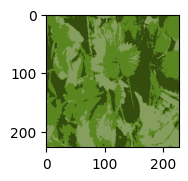

In [7]:
imgs = images[0]
img_aug = preprocess_image_with_segmentation_rgb(imgs)

plt.figure(figsize=(15,10))
for i, img in enumerate(img_aug):
    plt.subplot(5, 6, i+1)
    plt.imshow(np.squeeze(img))
plt.show()

# Menerapkan Segmentasi Ke Setiap Gambar
* ```segment_images = []```: Membuat list kosong untuk menyimpan gambar-gambar hasil segmentasi.
* Loop ```for i, image in enumerate(images)```: Iterasi melalui semua gambar dalam images.
* ```segment_images.extend(preprocess_image_with_segmentation_rgb(image))```: Memproses setiap gambar menggunakan ```preprocess_image_with_segmentation_rgb``` dan menambahkannya ke ```segment_images```.

In [8]:
segment_images = []

for i, image in enumerate(images):
    try:
        segment_images.extend(preprocess_image_with_segmentation_rgb(image))
    except:
        print(i)

# Augmentasi Gambar
Augmentasi data adalah proses menghasilkan data baru secara artifisial dari data yang ada, terutama untuk melatih model machine learning (ML) baru.
1. Inisialisasi
* ```images = []```: Membuat list kosong untuk menyimpan gambar-gambar hasil augmentasi.
* ```h, w, _ = img.shape```: Mendapatkan tinggi (h), lebar (w), dan channel warna dari gambar input (img).
* ```center = (w // 2, h // 2)```: Menentukan titik tengah gambar.
* ```scale = 1.5```: Faktor skala untuk proses zoom.
2. Rotasi
* ```cv.getRotationMatrix2D(center, 15, 1.0)```: Membuat matriks transformasi untuk rotasi sebesar 15 derajat terhadap titik tengah.
* ```cv.getRotationMatrix2D(center, -15, 1.0)```: Membuat matriks transformasi untuk rotasi sebesar -15 derajat terhadap titik tengah.
3. Translasi
* ```np.float32([[1, 0, 20], [0, 1, 0]])```: Matriks transformasi untuk translasi sebesar 20 piksel ke kanan.
* ```np.float32([[1, 0, -20], [0, 1, 0]])```: Matriks transformasi untuk translasi sebesar 20 piksel ke kiri.
4. menerapkan rotasi dan translasi
* transformations: List yang berisi semua transformasi yang akan diterapkan, yaitu dua rotasi dan dua translasi.
* Loop ```for transform in transformations:``` dan ```cv.warpAffine(img, transform, (w, h))```: Menerapkan transformasi menggunakan matriks transformasi transform pada gambar img dengan ukuran (w, h). Hasilnya ditambahkan ke dalam list images.
5. Zooming
* ```cv.resize(img, (new_w, new_h))```: Mengubah ukuran gambar menjadi ukuran baru sesuai dengan faktor skala (scale).
* ```crop_x = (new_w - w) // 2 dan crop_y = (new_h - h) // 2```: Menghitung area yang akan di-crop agar ukurannya sama dengan gambar asli.
* ```resized[crop_y:crop_y+h, crop_x:crop_x+w]```: Memotong bagian tengah dari gambar yang telah di-zoom.
6. Menyimpan hasil menggunakan fungsi ```images.append(cropped)```: Menambahkan gambar hasil zoom ke dalam list images

In [9]:
def Augmentation(img):
    images = []
    h, w, _ = img.shape
    center = (w // 2, h // 2)
    scale = 1.5

    rotation_15 = cv.getRotationMatrix2D(center, 15, 1.0)
    rotation_neg_15 = cv.getRotationMatrix2D(center, -15, 1.0)

    translation_20 = np.float32([[1, 0, 20], [0, 1, 0]])
    translation_neg_20 = np.float32([[1, 0, -20], [0, 1, 0]])

    # Transformation
    transformations = [
        rotation_15, rotation_neg_15,
        translation_20, translation_neg_20
    ]

    for transform in transformations:
        images.append(cv.warpAffine(img, transform, (w, h)))

    # Zooming
    new_w, new_h = int(w * scale), int(h * scale)
    resized = cv.resize(img, (new_w, new_h))

    if scale > 1.0:
        crop_x = (new_w - w) // 2
        crop_y = (new_h - h) // 2
        cropped = resized[crop_y:crop_y+h, crop_x:crop_x+w]
    images.append(cropped)

    return images

# Menampilkan gambar asli setelah segmentasi

(227, 227, 3)

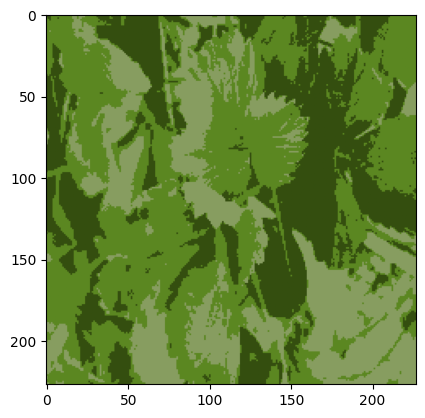

In [10]:
plt.imshow(segment_images[0])
images[0].shape

# Menampilkan gambar hasil Augmentasi
Pada kode ini mengambil satu gambar dari list segment_images untuk menampilkan hasil augmentasi yang dilakukan

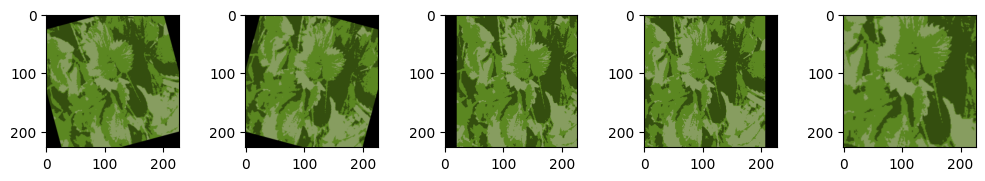

In [11]:
imgs = segment_images[0]
img_aug = Augmentation(imgs)

plt.figure(figsize=(15,10))
for i, img in enumerate(img_aug):
    plt.subplot(5, 6, i+1)
    plt.imshow(img)
plt.show()

# Menerapkan augmentasi pada semua gambar yang sudah dilakukan segmentasi
* ```augmen_images = []``` dan ```augmen_labels = []```: Membuat list kosong untuk menyimpan gambar-gambar hasil augmentasi dan label-label yang sesuai.
* Loop ```for i, image in enumerate(segment_images)```: Iterasi melalui semua gambar yang telah di-segmentasi sebelumnya.
* ```augmen_images.extend(Augmentation(image))```: Menggunakan fungsi Augmentation untuk melakukan augmentasi pada setiap gambar dan menambahkannya ke dalam augmen_images.
* ```augmen_labels.extend([names[i]]*5)```: Menambahkan label yang sesuai dengan gambar-gambar yang telah di-augmentasi ke dalam augmen_labels.

In [12]:
augmen_images = []
augmen_labels = []

for i, image in enumerate(segment_images):
    try:
        augmen_images.extend(Augmentation(image))
        augmen_labels.extend([names[i]]*5)
    except:
        print(i)

# Menambahkan gambar hasil augmentasi pada list segment_images

In [13]:
segment_images.extend(augmen_images)
names.extend(augmen_labels)

# Menampilkan jumlah gambar dan label setelah augmentasi
proses ini untuk memastikan bahwa gambar dan juga label memiliki jumlah yang sama

In [14]:
len(augmen_images), len(augmen_labels)

(7915, 7915)

# Menampilkan jumlah gambar pada setiap class

In [15]:
uniq, count = np.unique(augmen_labels, return_counts=True)
for i in zip(uniq, count):
    print(i)

('angular leafspot', 2175)
('leaf spot', 3075)
('powdery mildew leaf', 2665)


In [16]:
len(augmen_labels)

7915

# Label Encoder
Label Encoding adalah teknik yang digunakan untuk mengubah kolom kategoris menjadi kolom numerik sehingga dapat disesuaikan dengan model pembelajaran mesin yang hanya mengambil data numerik.
1. Inisialisasi Label Encoder
* ```le = LabelEncoder()```: Membuat objek ```LabelEncoder``` dari library ```scikit-learn```. ```LabelEncoder``` digunakan untuk mengubah label kelas menjadi angka secara berurutan.
2. Transformasi Label
* ```le.fit(augmen_labels)```: Melatih LabelEncoder dengan label kelas yang ada di augmen_labels. Ini akan memetakan setiap label unik ke sebuah bilangan bulat.
* ```name_vec = le.transform(augmen_labels)```: Mengubah setiap label kelas dalam ```augmen_labels``` menjadi bilangan bulat sesuai dengan mapping yang telah dilakukan oleh ```abelEncoder```.
3. One-Hot-Encoding
* ```categorical_names = to_categorical(name_vec)```: Melakukan one-hot encoding terhadap label bilangan bulat yang dihasilkan sebelumnya ```(name_vec)```. One-hot encoding mengubah setiap nilai menjadi vektor biner di mana semua elemen kecuali satu di dalam vektor biner memiliki nilai nol.

In [17]:
le = LabelEncoder()
le.fit(augmen_labels)
labels = le.classes_
name_vec = le.transform(augmen_labels)
categorical_names = to_categorical(name_vec)

# Mencetak jumlah kelas yang terenkoding

In [18]:
print(f"Number of class : {len(labels)}")
print(labels)

Number of class : 3
['angular leafspot' 'leaf spot' 'powdery mildew leaf']


# Mencetak hasil dari one-hot encoding
yaitu matriks di mana setiap baris mewakili vektor one-hot dari label yang sesuai.

In [19]:
print(categorical_names)

[[0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 ...
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]]


# Split Data
Memisahkan data menjadi subset train dan test untuk evaluasi model
* ```train_test_split```: Fungsi ini dari ```scikit-learn``` digunakan untuk membagi data menjadi subset train dan test secara acak.
* ```np.array(augmen_images, dtype=np.float32)```: Mengonversi list augmen_images menjadi array numpy dengan tipe data float32.
* ```np.array(categorical_names)```: Mengonversi ```categorical_names``` (yang merupakan hasil dari one-hot encoding) menjadi array numpy.
* ```test_size=0.3```: Menentukan proporsi data yang akan digunakan sebagai data test (30% dari data akan menjadi data test).
* ```random_state=42```: Menentukan seed untuk pengacakan data, sehingga pembagian akan konsisten jika kode dijalankan ulang dengan seed yang sama.

In [20]:
x_train, x_test, y_train, y_test = train_test_split(np.array(augmen_images, dtype=np.float32), 
                                                    np.array(categorical_names), 
                                                    test_size=0.3, random_state=42)

# Menampilkan dimensi data train dan juga test

In [21]:
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(5540, 227, 227, 3) (5540, 3) (2375, 227, 227, 3) (2375, 3)


# Reshape Data Train dan Test
* ```np.reshape```: Mengubah bentuk array ```x_train dan x_test``` sehingga setiap sampel gambar memiliki dimensi (227, 227, -1). Dimensi terakhir (-1) menyesuaikan dengan jumlah channel gambar (dalam kasus ini, mungkin channel warna atau fitur lainnya).

In [22]:
x_train = np.reshape(x_train, (len(x_train), 227, 227, -1))
x_test = np.reshape(x_test, (len(x_test), 227, 227, -1))

# Cetak Dimensi Data Train dan Test setelah Reshape

In [23]:
x_train.shape, x_test.shape

((5540, 227, 227, 3), (2375, 227, 227, 3))

# Early Stopping Callback
Callback dari Keras yang digunakan untuk menghentikan pelatihan saat metrik yang dimonitor (dalam hal ini, 'val_accuracy') tidak mengalami peningkatan dalam jumlah epoch yang ditentukan (patience=5). ```restore_best_weights=True``` akan mengembalikan bobot model ke titik terbaik selama pelatihan saat pelatihan dihentikan.

In [24]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

# Model AlexNet
1. Inisialisasi Model
* ```model = Sequential()```
* Membuat model Sequential, yang merupakan urutan lapisan-lapisan neural network.
2. Layer Convolutional
* contoh:
```model.add(keras.layers.Conv2D(96, 11, 4, activation='relu', input_shape=input_shape))```
* Menambahkan layer Conv2D dengan 96 filter, ukuran kernel 11x11, dengan langkah (stride) 4x4, dan aktivasi ReLU. input_shape adalah bentuk input pertama dalam model.
3. Batch Normalization
* Menambahkan layer BatchNormalization setelah layer Conv2D untuk mempercepat konvergensi selama pelatihan dan meningkatkan stabilitas.
4. Max Pooling
* Menambahkan layer MaxPooling untuk mengekstraksi fitur penting dari gambar dengan memilih nilai maksimum dari setiap jendela pooling.
5. Flatten Layer
* ```model.add(keras.layers.Flatten())```
* Meratakan output dari lapisan-lapisan sebelumnya menjadi vektor satu dimensi untuk persiapan masukan ke lapisan-lapisan Dense.
6. Lapisan Dense & Dropout
* contoh: 
``` model.add(keras.layers.Dense(4096, activation='relu'))
model.add(keras.layers.Dropout(0.5))```
* Menambahkan lapisan Dense dengan 4096 unit neuron, fungsi aktivasi ReLU, dan Dropout untuk mengurangi overfitting dengan mematikan secara acak unit-unit selama pelatihan.
7. Output Layer
* ```model.add(keras.layers.Dense(len(labels), activation='softmax'))``` 
* Menambahkan lapisan Dense terakhir dengan jumlah unit sesuai dengan jumlah kelas yang akan diprediksi (berdasarkan jumlah label yang terenkoding), dengan aktivasi softmax untuk output kelas-kelas probabilitas.
8. Compile model
* ```model.compile(optimizer=Adam(learning_rate=learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy'])```
* Mengkompilasi model dengan optimizer Adam yang mempertahankan pelajaran adaptif, fungsi loss categorical_crossentropy untuk klasifikasi multikelas, dan metrik akurasi untuk mengevaluasi performa model.
* ```model.summary()```: Menampilkan ringkasan arsitektur model yang telah dibangun, termasuk jumlah parameter yang dapat dipelajari dan non-trainable.

In [55]:
def AlexNet(input_shape, learning_rate):
  model = Sequential()

  model.add(keras.layers.Conv2D(96, 11, 4, activation='relu', input_shape = input_shape))
  model.add(keras.layers.BatchNormalization())
  model.add(keras.layers.MaxPool2D(3, 2))

  model.add(keras.layers.Conv2D(256, 5, activation = 'relu'))
  model.add(keras.layers.BatchNormalization())
  model.add(keras.layers.MaxPool2D(3, 2))

  model.add(keras.layers.Conv2D(384, 3, activation='relu'))
  model.add(keras.layers.Conv2D(384, 3, activation='relu'))
  model.add(keras.layers.Conv2D(256, 3, activation='relu'))
  model.add(keras.layers.MaxPool2D(3, 2))

  model.add(keras.layers.Flatten())
#   model.add(keras.layers.Dense(4096, activation='relu'))
#   model.add(keras.layers.Dropout(0.5))
  model.add(keras.layers.Dense(4096, activation='relu'))
  model.add(keras.layers.Dropout(0.5))
  model.add(keras.layers.Dense(len(labels), activation='softmax'))

  model.summary()
  model.compile(optimizer=Adam(learning_rate=learning_rate),
                loss = 'categorical_crossentropy',
                metrics = ['accuracy'])

  return model

# Training Model
* Memanggil metode ```fit``` pada model ```AlexNet``` dengan data ```x_train dan y_train``` untuk pelatihan selama beberapa epoch (epoch). ```shuffle=True``` untuk mengacak urutan sampel setiap epoch dan ```validation_split=0.15``` untuk menggunakan 15% data sebagai validasi.

In [57]:
input_shape = x_train[0].shape
epoch = 15
learning_rate = 0.0001
batch_size = 16
Alex_Net = AlexNet(input_shape, learning_rate)
history_AlexNet = Alex_Net.fit(x_train,
                            y_train,
                            epochs = epoch,
                            shuffle = True,
                            validation_split = 0.15,
                            )

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 55, 55, 96)     │        34,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 55, 55, 96)     │           384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 27, 27, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 23, 23, 256)    │       614,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 23, 23, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 11, 11, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 9, 9, 384)      │       885,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 7, 7, 384)      │     1,327,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 5, 5, 256)      │       884,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 4096)           │     4,198,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 3)              │        12,291 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,959,299 (30.36 MB)

 Trainable params: 7,958,595 (30.36 MB)

 Non-trainable params: 704 (2.75 KB)

Epoch 1/15
  5/148 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - accuracy: 0.3833 - loss: 1.1380

W0000 00:00:1719361714.224414     137 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.7235 - loss: 0.6216

W0000 00:00:1719361723.482573     136 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


148/148 ━━━━━━━━━━━━━━━━━━━━ 16s 68ms/step - accuracy: 0.7241 - loss: 0.6205 - val_accuracy: 0.4477 - val_loss: 1.7480
Epoch 2/15
148/148 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.8514 - loss: 0.3636 - val_accuracy: 0.4332 - val_loss: 1.5732
Epoch 3/15
148/148 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.9032 - loss: 0.2352 - val_accuracy: 0.6185 - val_loss: 1.1064
Epoch 4/15
148/148 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.9470 - loss: 0.1447 - val_accuracy: 0.4850 - val_loss: 2.1530
Epoch 5/15
148/148 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.9637 - loss: 0.1023 - val_accuracy: 0.5680 - val_loss: 1.1596
Epoch 6/15
148/148 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.9443 - loss: 0.1519 - val_accuracy: 0.5969 - val_loss: 1.1754
Epoch 7/15
148/148 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.9548 - loss: 0.1216 - val_accuracy: 0.8761 - val_loss: 0.3046
Epoch 8/15
148/148 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.9760 - loss: 0.0751 - val_accuracy: 0.78

# Evaluasi Model
Fungsi ini digunakan untuk menampilkan grafik kurva pelatihan dan validasi berdasarkan nilai akurasi dan loss dari objek history_AlexNet setelah model dilatih.

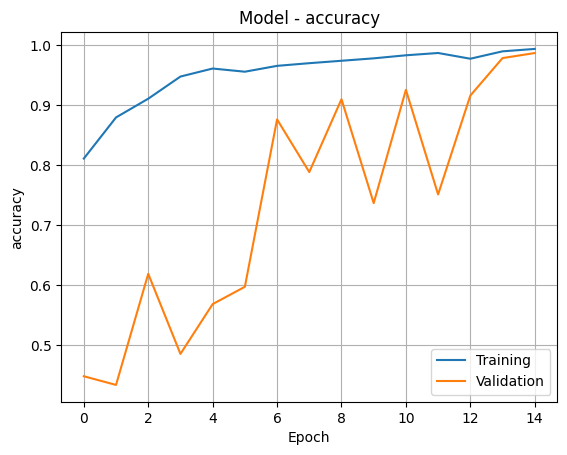

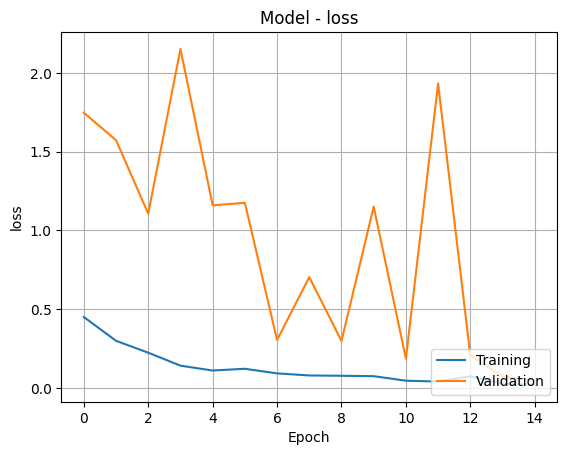

In [58]:
def evaluate_model(history_AlexNet):
    names = [['accuracy', 'val_accuracy'],
            ['loss', 'val_loss']]

    for name in names:
        fig1, ax_acc = plt.subplots()
        plt.plot(history_AlexNet.history[name[0]])
        plt.plot(history_AlexNet.history[name[1]])
        plt.xlabel('Epoch')
        plt.ylabel(name[0])
        plt.title(f'Model - {name[0]}')
        plt.legend(['Training', 'Validation'], loc='lower right')
        plt.grid()
        plt.show()

evaluate_model(history_AlexNet)

In [59]:
pred = Alex_Net.predict(x_test)

16/75 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

W0000 00:00:1719361803.864097     137 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step


## Clasiification Report
Menggunakan model yang sudah dilatih untuk membuat prediksi pada data test ```x_test```, kemudian mencetak laporan klasifikasi yang berisi precision, recall, dan f1-score untuk setiap kelas, berdasarkan hasil prediksi dan label sebenarnya ```(y_test)```.

In [60]:
print(classification_report(y_test.argmax(axis=1),
                            pred.argmax(axis=1),
                            target_names=labels))

                     precision    recall  f1-score   support

   angular leafspot       0.98      0.99      0.99       611
          leaf spot       1.00      0.97      0.98       927
powdery mildew leaf       0.98      1.00      0.99       837

           accuracy                           0.99      2375
          macro avg       0.99      0.99      0.99      2375
       weighted avg       0.99      0.99      0.99      2375



## Mencetak Confusion Matrix
Confusion matrix merupakan metode yang digunakan untuk mengukur atau melakukan perhitungan akurasi pada konsep data mining.

In [61]:
def confusionmatrix(cm, clasess,
                     normalize = False,
                     title = 'confusion matrix',
                     cmap = plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[np.newaxis]

    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()


    marks = np.arange(len(clasess))
    plt.xticks(marks, clasess, rotation=45)
    plt.yticks(marks, clasess)

    fmt = '.2f' if normalize else 'd'
    thres = cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment='center',
                color='white' if cm[i, j] > thres else "black")

    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predict label")
    plt.show()

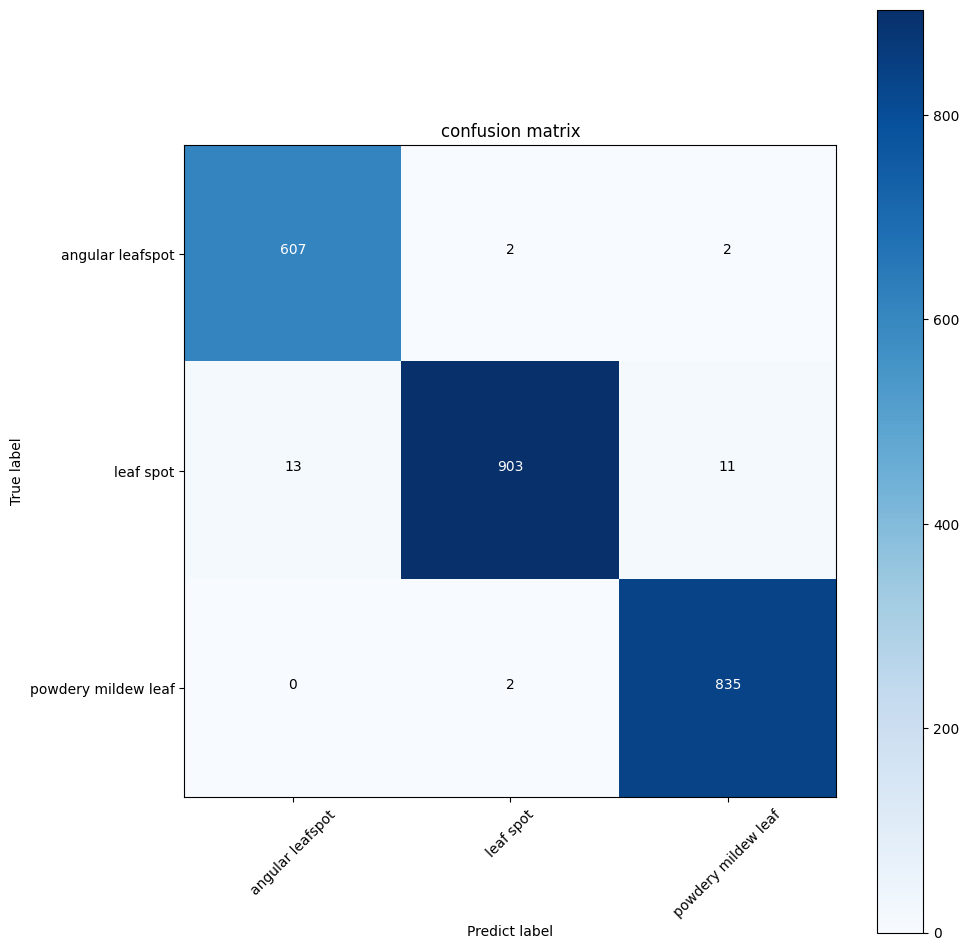

In [62]:
matrix = confusion_matrix(y_test.argmax(axis=1), pred.argmax(axis=1))
np.set_printoptions(precision=2)

confusionmatrix(matrix, clasess = labels, normalize=False, title='confusion matrix')

# Model Dense_Net 121
* ```base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=input_shape)```
* Mendefinisikan base_model menggunakan DenseNet121 yang telah dilatih sebelumnya pada dataset ImageNet. ```weights='imagenet'``` mengindikasikan penggunaan bobot praproses dari pelatihan pada ImageNet.
* ```include_top=False``` mengecualikan lapisan Dense terakhir (yang bertanggung jawab untuk klasifikasi 1000 kelas pada ImageNet), karena kita akan menambahkan lapisan klasifikasi khusus untuk dataset yang kita gunakan.
* ```input_shape=input_shape``` adalah bentuk input pertama dalam model.
* Menambahkan lapisan ```GlobalAveragePooling2D``` untuk meratakan output dari ```base_model```.
* Menambahkan lapisan Dense terakhir dengan 3 unit neuron (sesuai dengan jumlah kelas yang akan diprediksi), dan menggunakan aktivasi softmax untuk output klasifikasi multikelas.
* Membuat objek model dengan menyertakan base_model.input sebagai input dan predictions sebagai output.

Set Layer Trainable

```for layer in base_model.layers:
    layer.trainable = True```
* Mengatur semua layer dalam base_model agar dapat dilatih ulang (trainable=True), meskipun bobot awalnya telah diset dengan bobot dari DenseNet121 pre-trained.

In [32]:
def Dense_Net121(input_shape, learning_rate):
  base_model = DenseNet121(weights='imagenet', include_top = False, input_shape = input_shape)
  x = base_model.output
  x = GlobalAveragePooling2D()(x)
  x = Dense(1024, activation = 'relu')(x)
  predictions = Dense(3, activation = 'softmax')(x)
  model = Model(inputs = base_model.input, outputs = predictions)

  for layer in base_model.layers:
    layer.trainable = True

  model.summary()
  model.compile(optimizer=Adam(learning_rate=learning_rate),
                loss = 'categorical_crossentropy',
                metrics = ['accuracy'])

  return model

# Training Model Dense Net121

In [33]:
input_shape = x_train[0].shape
epoch = 15
learning_rate = 0.0001
batch_size = 15
Dense_Net = Dense_Net121(input_shape, learning_rate)
history_DenseNet = Dense_Net.fit(x_train,
                            y_train,
                            epochs = epoch,
                            shuffle = True,
                            validation_split = 0.15,
                            callbacks = [early_stopping])

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_16"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 227, 227,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 233, 233,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 114, 114,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 114, 114,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 114, 114,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 116, 116,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 57, 57,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 57, 57,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 57, 57,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 57, 57,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 57, 57,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 57, 57,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 57, 57,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 57, 57,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 57, 57,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 57, 57,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 57, 57,    │     12,288 │ conv2_block2_0_r

 Total params: 8,090,179 (30.86 MB)

 Trainable params: 8,006,531 (30.54 MB)

 Non-trainable params: 83,648 (326.75 KB)

Epoch 1/15


W0000 00:00:1719358165.362794     136 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 937ms/step - accuracy: 0.8762 - loss: 0.3216

W0000 00:00:1719358314.198354     137 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719358335.107303     136 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


148/148 ━━━━━━━━━━━━━━━━━━━━ 335s 1s/step - accuracy: 0.8767 - loss: 0.3205 - val_accuracy: 0.8953 - val_loss: 0.2854
Epoch 2/15
148/148 ━━━━━━━━━━━━━━━━━━━━ 47s 320ms/step - accuracy: 0.9957 - loss: 0.0161 - val_accuracy: 0.9940 - val_loss: 0.0237
Epoch 3/15
148/148 ━━━━━━━━━━━━━━━━━━━━ 47s 318ms/step - accuracy: 0.9874 - loss: 0.0352 - val_accuracy: 0.9964 - val_loss: 0.0142
Epoch 4/15
148/148 ━━━━━━━━━━━━━━━━━━━━ 47s 319ms/step - accuracy: 0.9876 - loss: 0.0313 - val_accuracy: 0.9976 - val_loss: 0.0064
Epoch 5/15
148/148 ━━━━━━━━━━━━━━━━━━━━ 47s 318ms/step - accuracy: 0.9904 - loss: 0.0311 - val_accuracy: 0.9988 - val_loss: 0.0050
Epoch 6/15
148/148 ━━━━━━━━━━━━━━━━━━━━ 47s 317ms/step - accuracy: 0.9985 - loss: 0.0039 - val_accuracy: 0.9976 - val_loss: 0.0082
Epoch 7/15
148/148 ━━━━━━━━━━━━━━━━━━━━ 47s 317ms/step - accuracy: 0.9758 - loss: 0.0725 - val_accuracy: 0.9988 - val_loss: 0.0041
Epoch 8/15
148/148 ━━━━━━━━━━━━━━━━━━━━ 47s 318ms/step - accuracy: 0.9991 - loss: 0.0040 - val_a

# Evaluasi Model Dense_Net121

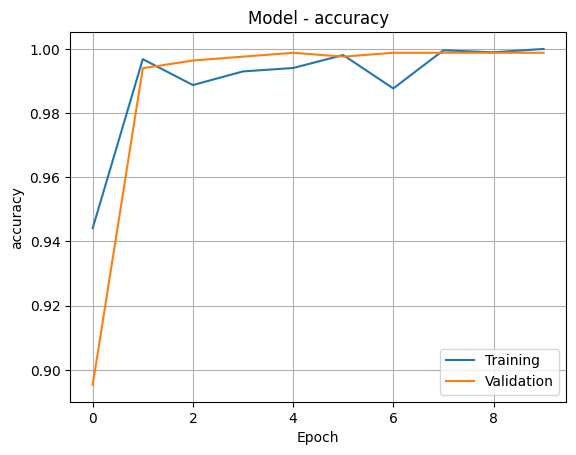

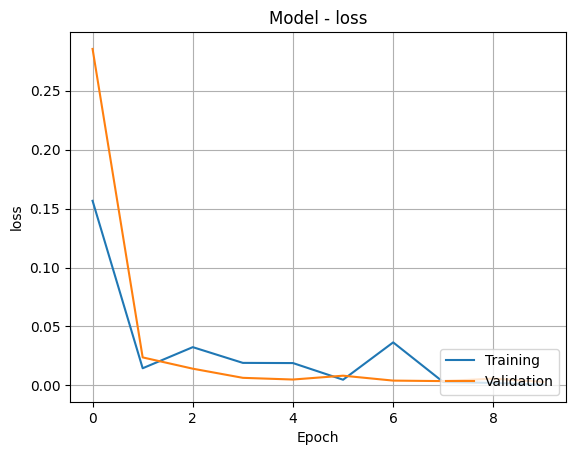

In [34]:
def evaluate_model(history_DenseNet):
    names = [['accuracy', 'val_accuracy'],
            ['loss', 'val_loss']]

    for name in names:
        fig1, ax_acc = plt.subplots()
        plt.plot(history_DenseNet.history[name[0]])
        plt.plot(history_DenseNet.history[name[1]])
        plt.xlabel('Epoch')
        plt.ylabel(name[0])
        plt.title(f'Model - {name[0]}')
        plt.legend(['Training', 'Validation'], loc='lower right')
        plt.grid()
        plt.show()

evaluate_model(history_DenseNet)

In [35]:
pred_DesneNet = Dense_Net.predict(x_test)

 3/75 ━━━━━━━━━━━━━━━━━━━━ 5s 82ms/step

W0000 00:00:1719358807.766309     136 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


75/75 ━━━━━━━━━━━━━━━━━━━━ 31s 298ms/step


### Classification report

In [36]:
print(classification_report(y_test.argmax(axis=1),
                            pred_DesneNet.argmax(axis=1),
                            target_names=labels))

                     precision    recall  f1-score   support

   angular leafspot       1.00      1.00      1.00       611
          leaf spot       1.00      1.00      1.00       927
powdery mildew leaf       1.00      1.00      1.00       837

           accuracy                           1.00      2375
          macro avg       1.00      1.00      1.00      2375
       weighted avg       1.00      1.00      1.00      2375



### Confusion Matrix

In [37]:
def confusionmatrix(cm, clasess,
                     normalize = False,
                     title = 'confusion matrix',
                     cmap = plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[np.newaxis]

    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()


    marks = np.arange(len(clasess))
    plt.xticks(marks, clasess, rotation=45)
    plt.yticks(marks, clasess)

    fmt = '.2f' if normalize else 'd'
    thres = cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment='center',
                color='white' if cm[i, j] > thres else "black")

    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predict label")
    plt.show()

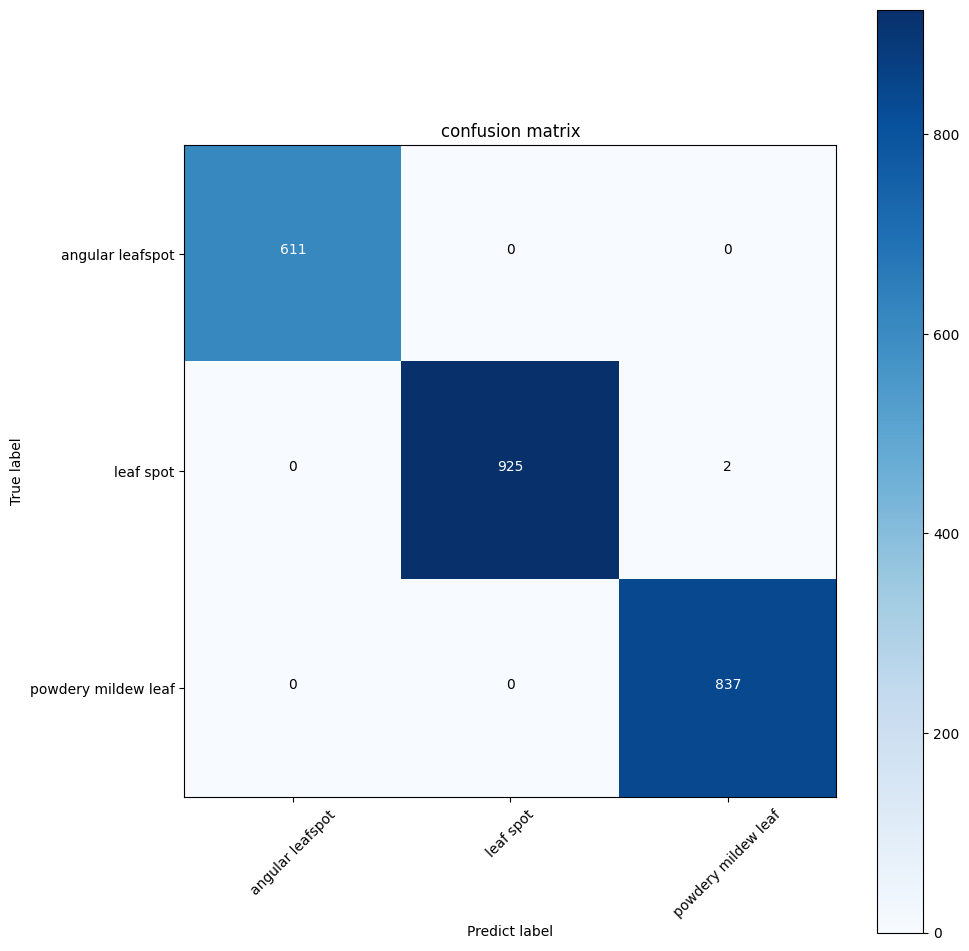

In [38]:
matrix = confusion_matrix(y_test.argmax(axis=1), pred_DesneNet.argmax(axis=1))
np.set_printoptions(precision=2)

confusionmatrix(matrix, clasess = labels, normalize=False, title='confusion matrix')

In [39]:
# Dense_Net.save('DenseNet121.h5')

# Model ResNet50


In [40]:
def ResNet_50(input_shape, learning_rate):
  base_model = ResNet50(weights = 'imagenet', include_top = False, input_shape = input_shape)
  x = base_model.output
  x = GlobalAveragePooling2D()(x)
  x = Dense(1024, activation = 'relu', kernel_regularizer=l2(0.01))(x)
  predictions = Dense(3, activation = 'softmax')(x)
  model = Model(inputs = base_model.input, outputs = predictions)

  for layer in base_model.layers:
    layer.trainable = True

  model.summary()
  model.compile(optimizer=Adam(learning_rate=learning_rate),
                loss = 'categorical_crossentropy',
                metrics = ['accuracy'])

  return model

## Training Model ResNet50

In [41]:
input_shape = x_train[0].shape
epoch = 50
learning_rate = 0.0001
batch_size = 16
Res_Net = ResNet_50(input_shape, learning_rate)
history_Res_Net = Res_Net.fit(x_train,
                            y_train,
                            epochs = epoch,
                            shuffle = True,
                            validation_split = 0.15,
                            )

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_18"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 227, 227,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 233, 233,  │          0 │ input_layer_2[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 114, 114,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 114, 114,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 114, 114,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 116, 116,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 57, 57,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 57, 57,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 57, 57,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 57, 57,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 57, 57,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 57, 57,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 57, 57,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 57, 57,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 57, 57,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 57, 57,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 57, 57,    │      1,024 │ conv2_block1_3_c

 Total params: 25,688,963 (98.00 MB)

 Trainable params: 25,635,843 (97.79 MB)

 Non-trainable params: 53,120 (207.50 KB)

Epoch 1/50


W0000 00:00:1719358913.978769     136 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 485ms/step - accuracy: 0.8833 - loss: 12.5210

W0000 00:00:1719358985.519154     136 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719358990.659760     139 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


148/148 ━━━━━━━━━━━━━━━━━━━━ 162s 592ms/step - accuracy: 0.8837 - loss: 12.5107 - val_accuracy: 0.2936 - val_loss: 9.9996
Epoch 2/50


W0000 00:00:1719359001.228249     138 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


148/148 ━━━━━━━━━━━━━━━━━━━━ 47s 316ms/step - accuracy: 0.9885 - loss: 7.0927 - val_accuracy: 0.2936 - val_loss: 5.7045
Epoch 3/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 46s 313ms/step - accuracy: 0.9878 - loss: 3.8417 - val_accuracy: 0.3538 - val_loss: 3.4655
Epoch 4/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 47s 314ms/step - accuracy: 0.9978 - loss: 2.0147 - val_accuracy: 0.3032 - val_loss: 2.7640
Epoch 5/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 46s 314ms/step - accuracy: 0.9795 - loss: 1.1313 - val_accuracy: 0.6113 - val_loss: 2.6258
Epoch 6/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 47s 315ms/step - accuracy: 0.9941 - loss: 0.6058 - val_accuracy: 0.7557 - val_loss: 1.1538
Epoch 7/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 47s 314ms/step - accuracy: 0.9982 - loss: 0.3295 - val_accuracy: 0.9434 - val_loss: 0.3607
Epoch 8/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 47s 314ms/step - accuracy: 0.9949 - loss: 0.1993 - val_accuracy: 0.9868 - val_loss: 0.1647
Epoch 9/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 47s 314ms/step - accuracy: 0.9929 - loss: 0.1294 - val

# Evaluasi Model ResNet50

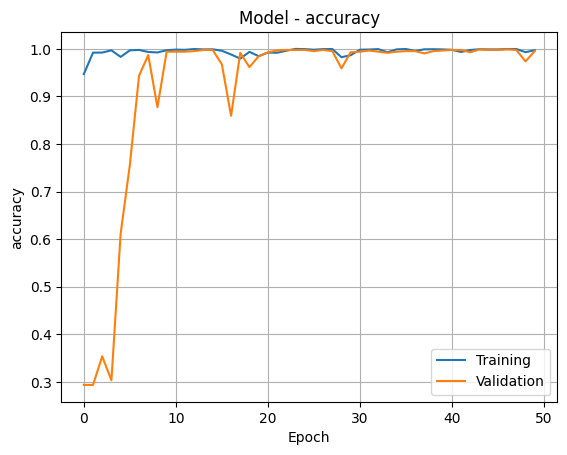

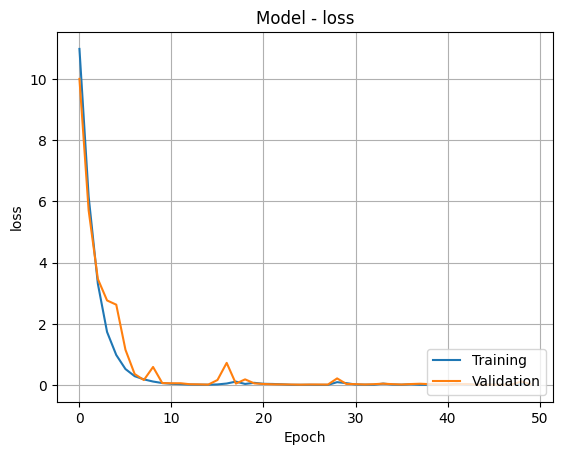

In [42]:
def evaluate_model(history_Res_Net):
    names = [['accuracy', 'val_accuracy'],
            ['loss', 'val_loss']]

    for name in names:
        fig1, ax_acc = plt.subplots()
        plt.plot(history_Res_Net.history[name[0]])
        plt.plot(history_Res_Net.history[name[1]])
        plt.xlabel('Epoch')
        plt.ylabel(name[0])
        plt.title(f'Model - {name[0]}')
        plt.legend(['Training', 'Validation'], loc='lower right')
        plt.grid()
        plt.show()

evaluate_model(history_Res_Net)

In [43]:
pred_ResNet = Res_Net.predict(x_test)

 2/75 ━━━━━━━━━━━━━━━━━━━━ 6s 96ms/step

W0000 00:00:1719361288.499713     138 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


75/75 ━━━━━━━━━━━━━━━━━━━━ 16s 170ms/step


W0000 00:00:1719361301.107365     137 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


### Classification Report

In [44]:
print(classification_report(y_test.argmax(axis=1),
                            pred_ResNet.argmax(axis=1),
                            target_names=labels))

                     precision    recall  f1-score   support

   angular leafspot       1.00      1.00      1.00       611
          leaf spot       1.00      0.99      1.00       927
powdery mildew leaf       0.99      1.00      1.00       837

           accuracy                           1.00      2375
          macro avg       1.00      1.00      1.00      2375
       weighted avg       1.00      1.00      1.00      2375



### Confusion Matrix

In [45]:
def confusionmatrix(cm, clasess,
                     normalize = False,
                     title = 'confusion matrix',
                     cmap = plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[np.newaxis]

    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()


    marks = np.arange(len(clasess))
    plt.xticks(marks, clasess, rotation=45)
    plt.yticks(marks, clasess)

    fmt = '.2f' if normalize else 'd'
    thres = cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment='center',
                color='white' if cm[i, j] > thres else "black")

    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predict label")
    plt.show()

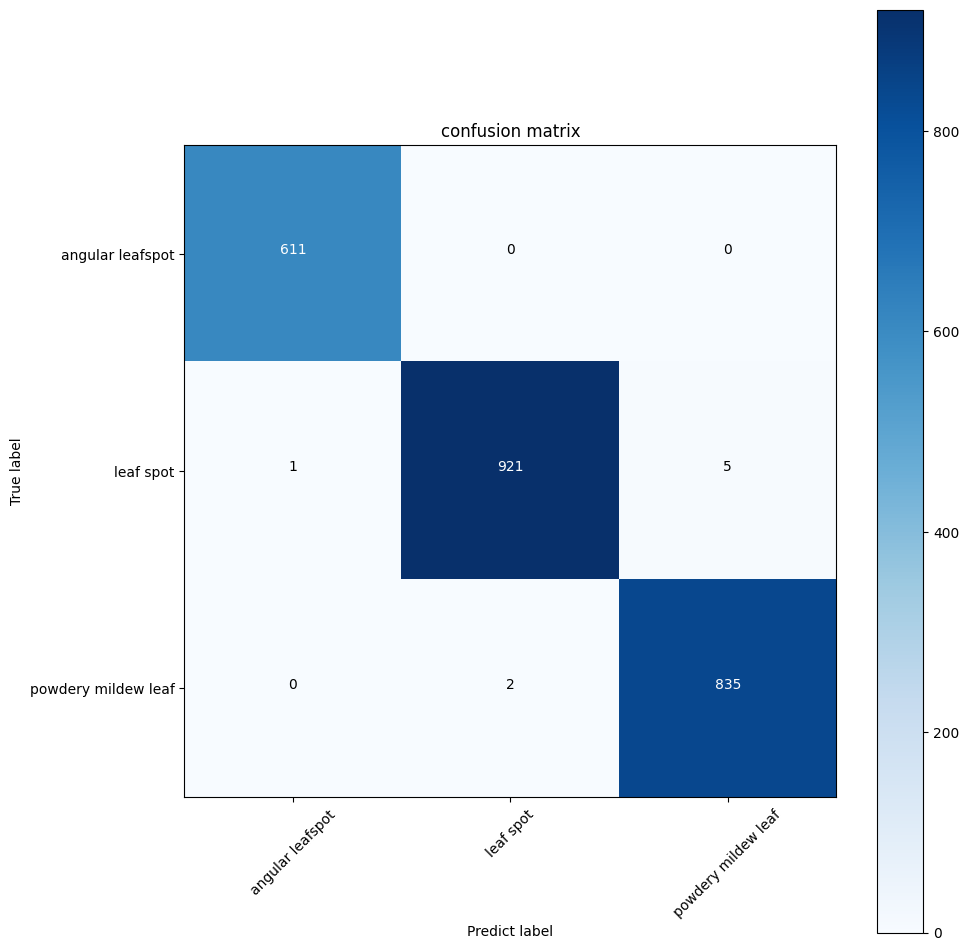

In [46]:
matrix = confusion_matrix(y_test.argmax(axis=1), pred_ResNet.argmax(axis=1))
np.set_printoptions(precision=2)

confusionmatrix(matrix, clasess = labels, normalize=False, title='confusion matrix')

# Prediction
Inisialisasi class name yang digunakan yang kemudian dilakuka preprocess data yang hampir sama dengan preprocess di awal

In [47]:
class_names = ['angular leafspot', 'leaf spot', 'powdery mildew leaf']

def preprocess_image(image_path, target_size):
    img = load_img(image_path, target_size=target_size)
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Menambahkan dimensi batch
    img_array /= 255.0  # Normalisasi
    return img_array

### Predict Image
Melakukan prediksi gambar pada semua model yang sudah dilakukan training

In [48]:
def predict_image(image_path, models, target_size):
    img_array = preprocess_image(image_path, target_size)

    predictions = {}
    for model_name, model in models.items():
        preds = model.predict(img_array)
        pred_class = class_names[np.argmax(preds)]
        predictions[model_name] = pred_class

    return predictions

### inisialisasi model yang sudah di training

In [49]:
target_size = (227, 227)
models = {
    'AlexNet': Alex_Net,
    'DenseNet121': Dense_Net,
    'ResNet50': Res_Net
}

# Menampilkan hasil prediksi
Pada bagian ini juga menginisialisasikan path dan juga label pada gambar, kemudian memanggil 2 fungsi diatas, dan menampilkan hasil prediksi.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


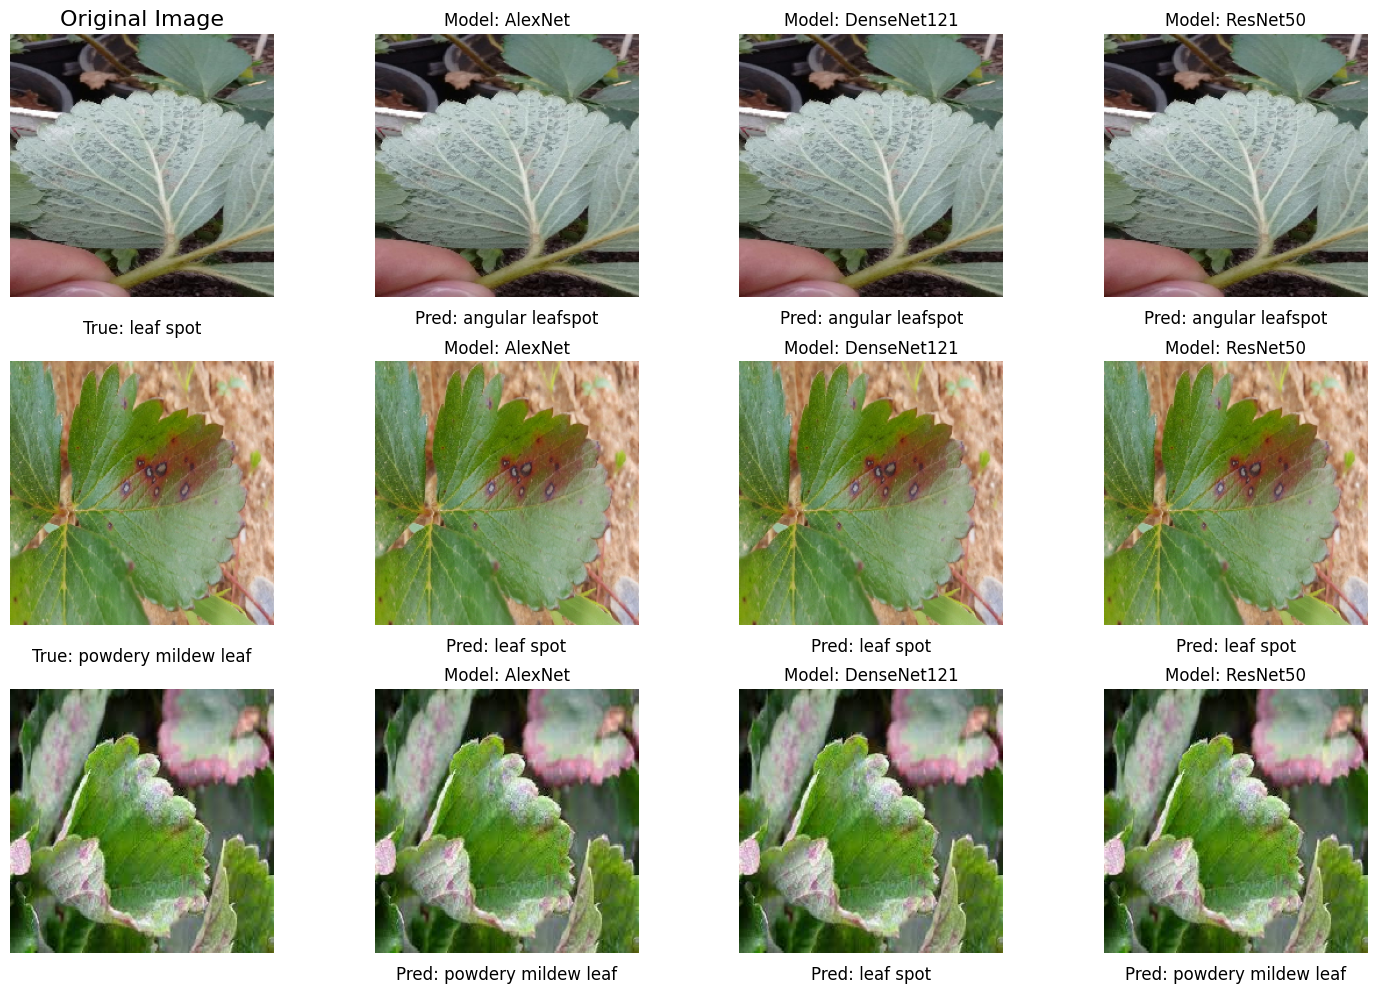

In [63]:
test_data = [('../input/strawberry-diseases-dataset/dataset/test/angular leafspot/angular leafspot3.jpg', 'angular leafspot'),
             ('../input/strawberry-diseases-dataset/dataset/test/leaf spot/leaf_spot3.jpg','leaf spot'),
             ('../input/strawberry-diseases-dataset/dataset/test/powdery mildew leaf/powdery mildew leaf4.jpeg', 'powdery mildew leaf')
        ]
test_data = np.vstack(test_data)
num_images = len(test_data)
num_models = len(models)
fig, axes = plt.subplots(num_images, num_models + 1, figsize=(15, 10))

for row, (image_path, true_label) in enumerate(test_data):
    predictions = predict_image(image_path, models, target_size)

    # Menampilkan gambar
    img = load_img(image_path, target_size=(227, 227))
    ax = axes[row, 0]
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(f"True: {true_label}", fontsize=12, pad=20)

    # Menampilkan prediksi dari setiap model
    for col, (model_name, prediction) in enumerate(predictions.items(), start=1):
        ax = axes[row, col]
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(f"Model: {model_name}", fontsize=12)
        ax.text(0.5, -0.1, f"Pred: {prediction}", fontsize=12, ha='center', transform=ax.transAxes)

# Set title untuk kolom pertama (gambar asli)
axes[0, 0].set_title('Original Image', fontsize=16)

# Set title untuk kolom prediksi model
# for col, model_title in enumerate(models.keys(), start=1):
#     axes[0, col].set_title(model_title, fontsize=16, pad=20)

plt.tight_layout()
plt.show()

# Save Model

In [1]:
Alex_Net.save('model/Aelx_Net.h5')
Dense_Net.save('model/DenseNet121.h5')
Res_Net.save('model/ResNet.h5')

NameError: name 'Alex_Net' is not defined